Welcome to the Demo for our "predict Measurements" portion of the code. The point of this section is to simulate the results of a range of measurement types, including direct measurement and M+N experiments. We do so in the following way:

1) Initialize a dataframe with relevant information for our molecule

2) Use this dataframe to calculate all isotopologues of our molecule and their concentrations

3) Pull out information about direct measurements

4) Pull out information about M+N measurements

5) Output this information as a .csv file

We also optionally allow the use to predict visual mass spectra for a molecule. 

Our example here will be C2NO2. This is not a real molecule, but offers a good mix of simplicity and complexity to allow the use to understand what is going on without being overwhelmed with millions of datapoints. 

In [1]:
run calcIsotopologues.py

In [2]:
run simulateMeasurements.py

Here, we define basic information about the molecule we will examine. This includes an "IDList", naming the sites, an "elIDs" list, identifying the chemical element at each, "numberAtSite", giving the number of atoms corresponding to each site, and "deltas", a list of delta values for each site. 

We also include some fragmentation vectors, and will simulate the results of these fragmentation measurements. 

In [3]:
############################################################################################################
###  First, initialize the molecule and the fragments we will be looking at. This includes an "IDList",  ###
###  which gives names to the sites, "elIDs", giving their chemical element, "numberAtSite", giving the  ###
###  number of atoms per site, "deltas", giving delta 13C vs PDB, 17O vs VSMOW, 33S vs CDT, 15N vs AIR,  ###
###  and D vs VSMOW. 18O and 34/36S are assigned delta values based on mass scaling laws. The details    ###
###  can be find in the basicDeltaOperations file.                                                       ###
###                                                                                                      ###
###  We then initialize the fragments, giving them entries of 1 or 'x' to indicate sites which are       ###
###  retained or lost. We put all this information into a dataFrame to easily check.                     ###
###                                                                                                      ###
############################################################################################################

##### INITIALIZE SITES #####
IDList = ['C-1','C-2','N-3','O-4','O-5']
elIDs = ['C','C','N','O','O']
numberAtSite = [1,1,1,1,1]

deltas = [25,-25,0,13,-13]

frag_70 = [1,1,1,1,1]
frag_54 = [1,1,1,1,'x']
frag_42 = ['x',1,1,1,'x']

l = [elIDs, numberAtSite, deltas, frag_70, frag_54, frag_42]

df = pd.DataFrame(l, columns = IDList)
df = df.transpose()
df.columns = ['IDS','Number','deltas','frag_70','frag_54','frag_42']

In [4]:
df

,IDS,Number,deltas,frag_70,frag_54,frag_42
C-1,C,1,25,1,1,x
C-2,C,1,-25,1,1,1
N-3,N,1,0,1,1,1
O-4,O,1,13,1,1,1
O-5,O,1,-13,1,x,x


The following steps calculate all isotopologues of a molecule and their concentrations. We encourage the user to look at what each of these variables are and correlate them to data objects from the M+N paper; they should be familiar. 

In [5]:
#This is the one variable that won't be correlated--it is a computational aid we will use later
siteElements = strSiteElements(df)

In [6]:
siteIsotopes, multinomialCoeff = calculateSetsOfSiteIsotopes(df)

In [7]:
bigA, SN = calcAllIsotopologues(siteIsotopes, multinomialCoeff)

In [8]:
concentrationArray = siteSpecificConcentrations(df)
d = calculateIsotopologueConcentrations(bigA, SN, concentrationArray)

d gives the concentration of all isotopologues

We develop two ways of indexing into and using the set of all isotopologues. In the first case, we index by type of substitution--I.e. bySub['13C'] gives all isotopologues with a single H substiution. In the second case, we explicitly write the vector representation for an isotopologue; i.e. byCondensed['10000'] for that isotopologue. 

In [9]:
bySub = calcSubDictionary(d, df)

In [10]:
byCondensed = calcCondensedDictionary(d, df)

In [11]:
###Should be = 1, minus floating point error
s = 0
for i, v in byCondensed.items():
    s += v['Conc']
print(s)

s = 0
for i, v in bySub.items():
    s += v['Conc']
print(s)

1.0000000000000002
1.0


Then we simulate the measurements we are interested in 

In [12]:
allMeasurementInfo = {}
allMeasurementInfo = directMeasurement(bySub, allMeasurementInfo, massThreshold = 3)

In [13]:
MN = massSelections(byCondensed, massThreshold = 4)

condensedFrags = [frag_54, frag_42]
expandedFrags = [expandFrag(x, numberAtSite) for x in condensedFrags]
fragKeys = ['54','42']

In [14]:
predictMNFragmentExpt(allMeasurementInfo, MN, expandedFrags, fragKeys, df, abundanceThreshold = 0.1)

{'Full': {'': 0.9696862013627834,
  '17O': 0.0007367675757954429,
  '18O': 0.0038888295419453067,
  '17O17O': 1.3992534964117162e-07,
  '17O18O': 7.295789014038658e-07,
  '18O17O': 7.473072975196862e-07,
  '15N': 0.003564566476209593,
  '15N17O': 2.7083576086240487e-06,
  '15N18O': 1.429533739619095e-05,
  '15N17O17O': 5.14365585280947e-10,
  '13C': 0.02179311556390774,
  '13C17O': 1.6558409205457103e-05,
  '13C18O': 8.739911065749559e-05,
  '13C17O17O': 3.1447382779755472e-09,
  '13C15N': 8.011149281292486e-05,
  '13C15N17O': 6.086871223926031e-08,
  '13C13C': 0.0001223702698579299,
  '13C13C17O': 9.297693103805514e-08,
  '13C13C15N': 4.4983311199775034e-07},
 'M0': {'54': {'': {'Abs. Abundance': 0.9696862013627834,
    'Rel. Abundance': 1.0,
    'Adj. Rel. Abundance': 1.0}},
  '42': {'': {'Abs. Abundance': 0.9696862013627834,
    'Rel. Abundance': 1.0,
    'Adj. Rel. Abundance': 1.0}}},
 'M1': {'54': {'15N': {'Abs. Abundance': 0.003564566476209593,
    'Rel. Abundance': 0.13660247787

In [15]:
fullMoleculeU = ['13C','15N','17O','18O','13C13C','13C18O','18O18O']
out = measurementToDf(allMeasurementInfo, bySub, fullMoleculeU)

Our simulation gives the following output

In [16]:
pd.set_option("precision", 15)
pd.set_option('display.max_rows', 500)
out

,Abs. Abundance,Rel. Abundance,Adj. Rel. Abundance
13C U Value,0.022474400000000,0.022474400000000,0.022474400000000
15N U Value,0.003676000000000,0.003676000000000,0.003676000000000
17O U Value,0.000759800000000,0.000759800000000,0.000759800000000
18O U Value,0.004010400000000,0.004010400000000,0.004010400000000
13C13C U Value,0.000126195742175,0.000126195742175,0.000126195742175
13C18O U Value,0.000090131333760,0.000090131333760,0.000090131333760
18O18O U Value,0.000004018314023,0.000004018314023,0.000004018314023
M0 54,0.969686201362783,1.000000000000000,1.000000000000000
M0 42,0.969686201362783,1.000000000000000,1.000000000000000
M1 54 15N,0.003564566476210,0.136602477870845,0.140571463534019


In [17]:
out.to_csv('M+N Demo C2NO2 Changed.csv')

We can generate simulated spectra in the following way

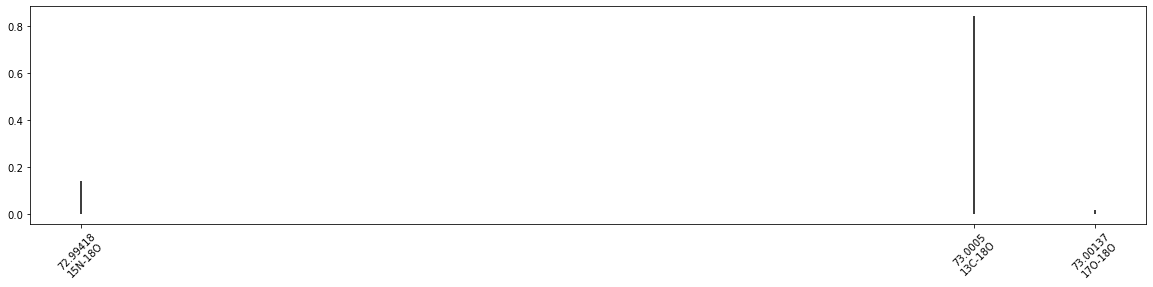

In [18]:
import matplotlib.pyplot as plt

#####PREDICT FULL SPECTRUM (NO FRAGMENT) #####
#####CUT OFF ISOTOPOLOGUES WITH LOW REL ABUNDANCE #####

##### TO DO: Integrate this with remainder of the code #####
selectedIsotopologues = MN['M3']
lowAbundanceCutOff = 0.01
massError = -0.000


predictSpectrum = {}
for key, item in selectedIsotopologues.items():
    mass = computeMass(key, siteElements)
    correctedMass = mass + massError
    subs = computeSubs(key, siteElements)
    
    if correctedMass not in predictSpectrum:
        predictSpectrum[correctedMass] = {'Abs. Abundance':0}
        
        if 'Sub' not in predictSpectrum[correctedMass]:
            predictSpectrum[correctedMass]['Sub'] = subs
            
    predictSpectrum[correctedMass]['Abs. Abundance'] += item['Conc']
    
totalAbundance = 0
for key, item in predictSpectrum.items():
    totalAbundance += item['Abs. Abundance']
    
massPlot = []
relAbundPlot = []
subPlot = []
for key, item in predictSpectrum.items():
    item['Rel. Abundance'] = item['Abs. Abundance'] / totalAbundance
    massPlot.append(key)
    relAbundPlot.append(item['Rel. Abundance'])
    subPlot.append(item['Sub'])
    
fig, ax = plt.subplots(figsize = (20,4))
massPlotcutOff = []
subPlotcutOff = []
for i in range(len(massPlot)):
    if relAbundPlot[i] > lowAbundanceCutOff:
        ax.vlines(massPlot[i], 0, relAbundPlot[i])
        massPlotcutOff.append(massPlot[i])
        subPlotcutOff.append(subPlot[i])
ax.set_xticks(massPlotcutOff)
labels = [str(round(x,5)) +'\n' + y for x,y in zip(massPlotcutOff,subPlotcutOff)]
ax.set_xticklabels(labels,rotation = 45);
    

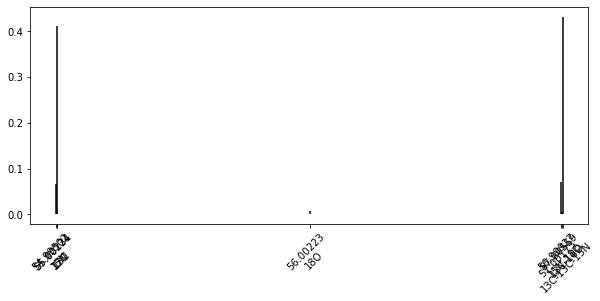

In [19]:
##### PREDICT SPECTRUM WITH FRAGMENTATION #####
selectedIsotopologues = MN["M3"]
lowAbundanceCutOff = 0.001
massError = 0.000
fragment = expandFrag(frag_54, list(df['Number'].values))
bounds = None



##### Fragment Isotopologues #####
fragmentedDict = {}
for isotopologue, data in selectedIsotopologues.items():
    frag = [fragMult(x,y) for x, y in zip(fragment, isotopologue)]
    newIsotopologue = ''.join(frag)
    if newIsotopologue not in fragmentedDict:
        fragmentedDict[newIsotopologue] = 0
    fragmentedDict[newIsotopologue] += data['Conc']

selectedIsotopologues = fragmentedDict


##### Predict Spectrum #####
predictSpectrum = {}
for key, item in selectedIsotopologues.items():
    mass = computeMass(key, siteElements)
    correctedMass = mass + massError
    subs = computeSubs(key, siteElements)
    
    if correctedMass not in predictSpectrum:
        predictSpectrum[correctedMass] = {'Abs. Abundance':0}
        
        if 'Sub' not in predictSpectrum[correctedMass]:
            predictSpectrum[correctedMass]['Sub'] = subs
            
    predictSpectrum[correctedMass]['Abs. Abundance'] += item
    
totalAbundance = 0
for key, item in predictSpectrum.items():
    totalAbundance += item['Abs. Abundance']
    
massPlot = []
relAbundPlot = []
subPlot = []
for key, item in predictSpectrum.items():
    item['Rel. Abundance'] = item['Abs. Abundance'] / totalAbundance
    massPlot.append(key)
    relAbundPlot.append(item['Rel. Abundance'])
    subPlot.append(item['Sub'])
    
fig, ax = plt.subplots(figsize = (10,4))
massPlotcutOff = []
subPlotcutOff = []
for i in range(len(massPlot)):
    if relAbundPlot[i] > lowAbundanceCutOff:
        ax.vlines(massPlot[i], 0, relAbundPlot[i])
        massPlotcutOff.append(massPlot[i])
        subPlotcutOff.append(subPlot[i])
ax.set_xticks(massPlotcutOff)
labels = [str(round(x,5)) +'\n' + y for x,y in zip(massPlotcutOff,subPlotcutOff)]
ax.set_xticklabels(labels,rotation = 45);
if bounds != None:
    ax.set_xlim(bounds[0],bounds[1])
#ax.set_xlim(107.035, 107.07)
    